In [1]:
pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 77.9 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nibabel

  Using cached nibabel-5.3.2-py3-none-any.whl.metadata (9.1 kB)
Using cached nibabel-5.3.2-py3-none-any.whl (3.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    CropForegroundd, ScaleIntensityRanged, DivisiblePadd, ToTensord
)
from monai.data import Dataset, DataLoader
from monai.networks.utils import one_hot
import sagemaker
import boto3 

2025-09-23 08:57:34.015244: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-23 08:57:34.184794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758617854.211043    1424 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758617854.222242    1424 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-23 08:57:34.428928: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
bucket_name = 'shariya-data-2025'
prefix_tissue = 'tissue_mask/'
prefix_l3 = 'l3_mask/'

s3 = boto3.client('s3')
local_tissue_dir = 'data/tissue_mask'
local_l3_dir = 'data/l3_mask'


os.makedirs(local_tissue_dir, exist_ok=True)
os.makedirs(local_l3_dir, exist_ok=True)

def download_folder(bucket, prefix, local_dir):
    response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
    for obj in response.get('Contents', []):
        key = obj['Key']
        if not key.endswith('/'):  # Skip folder keys
            local_path = os.path.join(local_dir, os.path.basename(key))
            s3.download_file(bucket, key, local_path)
            print(f"Downloaded: {local_path}")

download_folder(bucket_name, prefix_l3, local_l3_dir)
download_folder(bucket_name, prefix_tissue, local_tissue_dir)


Downloaded: data/l3_mask/001_L3.nii.gz
Downloaded: data/l3_mask/002_L3.nii.gz
Downloaded: data/l3_mask/003_L3.nii.gz
Downloaded: data/l3_mask/004_L3.nii.gz
Downloaded: data/l3_mask/005_L3.nii.gz
Downloaded: data/l3_mask/006_L3.nii.gz
Downloaded: data/l3_mask/007_L3.nii.gz
Downloaded: data/l3_mask/008_L3.nii.gz
Downloaded: data/l3_mask/009_L3.nii.gz
Downloaded: data/l3_mask/010_L3.nii.gz
Downloaded: data/l3_mask/011_L3.nii.gz
Downloaded: data/l3_mask/012_L3.nii.gz
Downloaded: data/l3_mask/013_L3.nii.gz
Downloaded: data/l3_mask/014_L3.nii.gz
Downloaded: data/l3_mask/015_L3.nii.gz
Downloaded: data/l3_mask/016_L3.nii.gz
Downloaded: data/l3_mask/017_L3.nii.gz
Downloaded: data/l3_mask/018_L3.nii.gz
Downloaded: data/l3_mask/019_L3.nii.gz
Downloaded: data/l3_mask/020_L3.nii.gz
Downloaded: data/l3_mask/021_L3.nii.gz
Downloaded: data/l3_mask/022_L3.nii.gz
Downloaded: data/l3_mask/023_L3.nii.gz
Downloaded: data/l3_mask/024_L3.nii.gz
Downloaded: data/l3_mask/025_L3.nii.gz
Downloaded: data/l3_mask/

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
epochs = 20
lr = 1e-4
num_classes = 2 
batch_size = 1
save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)


In [21]:
from monai.utils import set_determinism
set_determinism(seed=42)
images_dir = "data/tissue_mask"
labels_dir = "data/l3_mask"

In [22]:
import glob
image_files = sorted(glob.glob(os.path.join(images_dir, "*.nii.gz")))
label_files = sorted(glob.glob(os.path.join(labels_dir, "*_L3.nii.gz")))

In [23]:
data_dicts = [
    {"image": img, "label": lbl}
    for img, lbl in zip(image_files, label_files)
]

In [24]:
print(len(data_dicts))

120


In [25]:
from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(data_dicts, test_size=0.2, random_state=42)

In [26]:

data_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=3, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 1.5), mode=("bilinear", "nearest")),
    DivisiblePadd(keys=["image", "label"], k=16),  
    ToTensord(keys=["image", "label"]),
])

In [27]:
train_transforms = Compose(data_transforms)
val_transforms = Compose(data_transforms)

In [28]:
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds   = Dataset(data=val_files, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

In [29]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=num_classes,  # binary segmentation
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm="instance"
).to(device)

In [30]:
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [31]:
dice_metric = DiceMetric(
    include_background=True,
    reduction="none",  
    get_not_nans=True
)


In [32]:
train_losses = []
val_losses = []
train_dice_scores = []
val_dice_scores = []


In [33]:
weights_dir = "Model/weights"       
checkpoints_dir = "Model"  

In [34]:
from monai.networks.utils import one_hot

for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")
    model.train()
    epoch_loss = 0
    dice_metric.reset()

    train_pbar = tqdm(train_loader, desc=f"Training {epoch}/{epochs}", ncols=100)

    for batch_data in train_pbar:
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device).long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        with torch.no_grad():
            preds = torch.argmax(outputs, dim=1, keepdim=True)
            preds_onehot = one_hot(preds, num_classes=num_classes)
            labels_onehot = one_hot(labels, num_classes=num_classes)
            dice_metric(y_pred=preds_onehot, y=labels_onehot)

        train_pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_train_loss = epoch_loss / len(train_loader)
    train_dice, _ = dice_metric.aggregate(reduction="mean")
    mean_train_dice = train_dice.item()
    dice_metric.reset()

    #Validation
    model.eval()
    val_loss = 0.0
    dice_metric.reset()

    with torch.no_grad():
        for val_data in val_loader:
            val_inputs = val_data["image"].to(device)
            val_labels = val_data["label"].to(device).long()

            val_outputs = model(val_inputs)
            v_loss = loss_function(val_outputs, val_labels)
            val_loss += v_loss.item()

            val_preds = torch.argmax(val_outputs, dim=1, keepdim=True)
            val_preds_onehot = one_hot(val_preds, num_classes=num_classes)
            val_labels_onehot = one_hot(val_labels, num_classes=num_classes)

            dice_metric(y_pred=val_preds_onehot, y=val_labels_onehot)

    avg_val_loss = val_loss / len(val_loader)
    val_dice, _ = dice_metric.aggregate(reduction="mean")
    mean_val_dice = val_dice.item()
    dice_metric.reset()

    print(f"\nEpoch Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Dice: {mean_train_dice:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f} | Val Dice:   {mean_val_dice:.4f}")

    # 🔸 Save model
    # ---- Save lightweight weights ----
    weights_path = os.path.join(weights_dir, f"model_epoch_{epoch}.pth")
    torch.save(model.state_dict(), weights_path)

    # ---- Save full checkpoint ----
    checkpoint_path = os.path.join(checkpoints_dir, f"checkpoint_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
    }, checkpoint_path)


    # 🔸 Save metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_dice_scores.append(mean_train_dice)
    val_dice_scores.append(mean_val_dice)



Epoch 1/20


Training 1/20: 100%|███████████████████████████████████| 96/96 [06:33<00:00,  4.10s/it, loss=1.0697]



Epoch Summary:
  Train Loss: 1.1677 | Train Dice: 0.4595
  Val Loss:   1.0612 | Val Dice:   0.5168

Epoch 2/20


Training 2/20: 100%|███████████████████████████████████| 96/96 [06:22<00:00,  3.98s/it, loss=0.8943]



Epoch Summary:
  Train Loss: 0.9735 | Train Dice: 0.4993
  Val Loss:   0.8951 | Val Dice:   0.5207

Epoch 3/20


Training 3/20: 100%|███████████████████████████████████| 96/96 [06:19<00:00,  3.95s/it, loss=0.7885]



Epoch Summary:
  Train Loss: 0.8386 | Train Dice: 0.5001
  Val Loss:   0.7886 | Val Dice:   0.5325

Epoch 4/20


Training 4/20: 100%|███████████████████████████████████| 96/96 [06:26<00:00,  4.03s/it, loss=0.7151]



Epoch Summary:
  Train Loss: 0.7504 | Train Dice: 0.5997
  Val Loss:   0.7165 | Val Dice:   0.6709

Epoch 5/20


Training 5/20: 100%|███████████████████████████████████| 96/96 [06:24<00:00,  4.01s/it, loss=0.6636]



Epoch Summary:
  Train Loss: 0.6892 | Train Dice: 0.6908
  Val Loss:   0.6667 | Val Dice:   0.6681

Epoch 6/20


Training 6/20: 100%|███████████████████████████████████| 96/96 [06:35<00:00,  4.12s/it, loss=0.6336]



Epoch Summary:
  Train Loss: 0.6461 | Train Dice: 0.6983
  Val Loss:   0.6293 | Val Dice:   0.7022

Epoch 7/20


Training 7/20: 100%|███████████████████████████████████| 96/96 [06:30<00:00,  4.07s/it, loss=0.6016]



Epoch Summary:
  Train Loss: 0.6140 | Train Dice: 0.7160
  Val Loss:   0.6032 | Val Dice:   0.6882

Epoch 8/20


Training 8/20: 100%|███████████████████████████████████| 96/96 [06:19<00:00,  3.96s/it, loss=0.5874]



Epoch Summary:
  Train Loss: 0.5896 | Train Dice: 0.7206
  Val Loss:   0.5814 | Val Dice:   0.6957

Epoch 9/20


Training 9/20: 100%|███████████████████████████████████| 96/96 [06:22<00:00,  3.99s/it, loss=0.5600]



Epoch Summary:
  Train Loss: 0.5701 | Train Dice: 0.7277
  Val Loss:   0.5657 | Val Dice:   0.6858

Epoch 10/20


Training 10/20: 100%|██████████████████████████████████| 96/96 [06:30<00:00,  4.06s/it, loss=0.5449]



Epoch Summary:
  Train Loss: 0.5535 | Train Dice: 0.7342
  Val Loss:   0.5498 | Val Dice:   0.6920

Epoch 11/20


Training 11/20: 100%|██████████████████████████████████| 96/96 [06:24<00:00,  4.00s/it, loss=0.5418]



Epoch Summary:
  Train Loss: 0.5387 | Train Dice: 0.7397
  Val Loss:   0.5389 | Val Dice:   0.6935

Epoch 12/20


Training 12/20: 100%|██████████████████████████████████| 96/96 [06:37<00:00,  4.14s/it, loss=0.5138]



Epoch Summary:
  Train Loss: 0.5259 | Train Dice: 0.7483
  Val Loss:   0.5268 | Val Dice:   0.7158

Epoch 13/20


Training 13/20: 100%|██████████████████████████████████| 96/96 [06:29<00:00,  4.06s/it, loss=0.5078]



Epoch Summary:
  Train Loss: 0.5137 | Train Dice: 0.7585
  Val Loss:   0.5155 | Val Dice:   0.7032

Epoch 14/20


Training 14/20: 100%|██████████████████████████████████| 96/96 [06:36<00:00,  4.14s/it, loss=0.4857]



Epoch Summary:
  Train Loss: 0.5027 | Train Dice: 0.7568
  Val Loss:   0.5065 | Val Dice:   0.7145

Epoch 15/20


Training 15/20: 100%|██████████████████████████████████| 96/96 [06:33<00:00,  4.09s/it, loss=0.4801]



Epoch Summary:
  Train Loss: 0.4899 | Train Dice: 0.7693
  Val Loss:   0.4987 | Val Dice:   0.7085

Epoch 16/20


Training 16/20: 100%|██████████████████████████████████| 96/96 [06:30<00:00,  4.07s/it, loss=0.4912]



Epoch Summary:
  Train Loss: 0.4782 | Train Dice: 0.7688
  Val Loss:   0.4870 | Val Dice:   0.7194

Epoch 17/20


Training 17/20: 100%|██████████████████████████████████| 96/96 [06:31<00:00,  4.07s/it, loss=0.4978]



Epoch Summary:
  Train Loss: 0.4660 | Train Dice: 0.7626
  Val Loss:   0.4770 | Val Dice:   0.7034

Epoch 18/20


Training 18/20: 100%|██████████████████████████████████| 96/96 [06:22<00:00,  3.98s/it, loss=0.4294]



Epoch Summary:
  Train Loss: 0.4479 | Train Dice: 0.7821
  Val Loss:   0.4587 | Val Dice:   0.7265

Epoch 19/20


Training 19/20: 100%|██████████████████████████████████| 96/96 [06:25<00:00,  4.01s/it, loss=0.4993]



Epoch Summary:
  Train Loss: 0.4276 | Train Dice: 0.7916
  Val Loss:   0.4485 | Val Dice:   0.7235

Epoch 20/20


Training 20/20: 100%|██████████████████████████████████| 96/96 [06:26<00:00,  4.03s/it, loss=0.3591]



Epoch Summary:
  Train Loss: 0.4030 | Train Dice: 0.8013
  Val Loss:   0.4331 | Val Dice:   0.7319


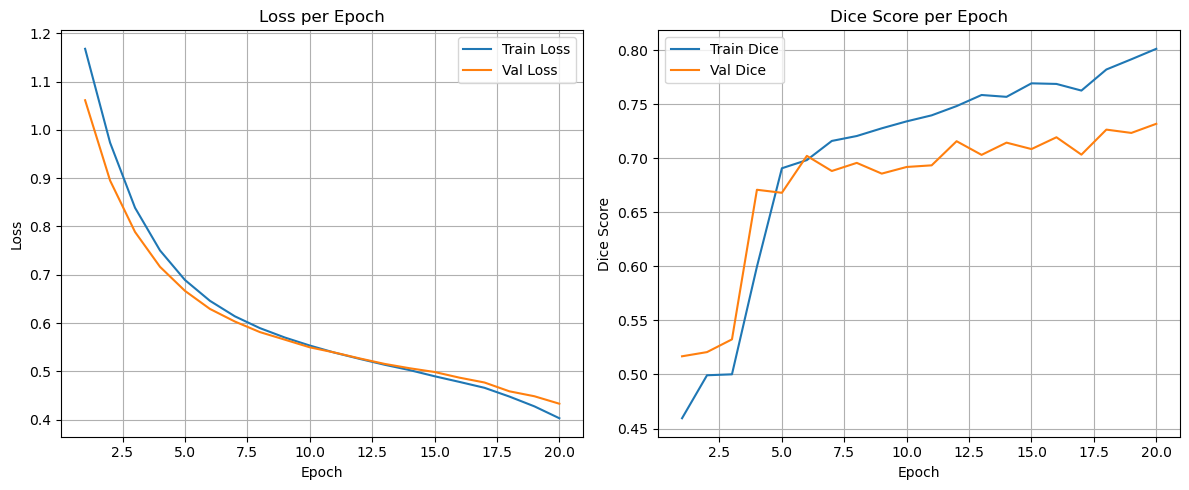

In [35]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot dice
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_dice_scores, label='Train Dice')
plt.plot(epochs_range, val_dice_scores, label='Val Dice')
plt.title('Dice Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
